In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer

In [66]:
df = pd.read_csv('data/data.csv')
df.shape

df['Date'] = pd.to_datetime(df['Date']).dt.date


In [67]:
for col in df.columns:
    if 'angle' in col or 'amf' in col[-3:]:
        df.drop([col], axis=1, inplace=True)

drop_cols = ['L3_CH4_CH4_column_volume_mixing_ratio_dry_air', 'L3_CH4_aerosol_height', 'L3_CH4_aerosol_optical_depth']
df.drop(drop_cols, axis=1, inplace=True)

In [68]:
use = list(df.columns[8:]) + ['target']
corr_df = df[use].corr().abs()

upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))

threshold = 0.7
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold) and column != 'temperature_2m_above_ground' and column !='L3_HCHO_tropospheric_HCHO_column_number_density']
print(f'Columns to drop [{len(to_drop)}]:', to_drop)

df.drop(to_drop, axis=1, inplace=True)
df = df.drop(columns=['L3_HCHO_HCHO_slant_column_number_density'])
df.info()

print(df[['target']].min(),df[['target']].max())


Columns to drop [16]: ['specific_humidity_2m_above_ground', 'L3_NO2_NO2_slant_column_number_density', 'L3_NO2_stratospheric_NO2_column_number_density', 'L3_NO2_tropospheric_NO2_column_number_density', 'L3_O3_cloud_fraction', 'L3_CO_H2O_column_number_density', 'L3_CO_sensor_altitude', 'L3_HCHO_cloud_fraction', 'L3_CLOUD_cloud_base_pressure', 'L3_CLOUD_cloud_fraction', 'L3_CLOUD_cloud_top_height', 'L3_CLOUD_cloud_top_pressure', 'L3_AER_AI_absorbing_aerosol_index', 'L3_SO2_SO2_slant_column_number_density', 'L3_SO2_absorbing_aerosol_index', 'L3_SO2_cloud_fraction']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 28 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Place_ID X Date                                  30557 non-null  object 
 1   Date                                             30557 non-null  object 
 2   Place_

In [69]:
leak_or_meta = set(
    ['pm25_bin','zone','no2_bin', 'Place_ID', 'Date', 'Place_ID X Date',
     'target_min','target_max','target_variance','target_count','target']
)

U = df['u_component_of_wind_10m_above_ground']
V = df['v_component_of_wind_10m_above_ground']
# 1) Wind speed (m/s)
df['wind_speed'] = np.hypot(U.to_numpy(), V.to_numpy())
print(df[['wind_speed']].min(),df[['wind_speed']].max())

# numeric feature set
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in leak_or_meta]

# compute Pearson r for each numeric column vs target
pearson = df[num_cols].corrwith(df['target']).dropna()

# sort by absolute correlation, highest first
pearson_sorted = pearson.reindex(pearson.abs().sort_values(ascending=False).index)

print("Top 25 by |Pearson r| with target:")
print(pearson_sorted.head(25))

print('=======')

print(df[['L3_CO_CO_column_number_density']].min(),df[['L3_CO_CO_column_number_density']].max())
print(df[['L3_HCHO_tropospheric_HCHO_column_number_density']].min(),df[['L3_HCHO_tropospheric_HCHO_column_number_density']].max())
print(df[['L3_AER_AI_sensor_altitude']].min(),df[['L3_AER_AI_sensor_altitude']].max())
print(df[['u_component_of_wind_10m_above_ground']].min(),df[['u_component_of_wind_10m_above_ground']].max())
print(df[['v_component_of_wind_10m_above_ground']].min(),df[['v_component_of_wind_10m_above_ground']].max())








wind_speed    0.02004
dtype: float64 wind_speed    18.160623
dtype: float64
Top 25 by |Pearson r| with target:
L3_CO_CO_column_number_density                     0.375737
L3_HCHO_tropospheric_HCHO_column_number_density    0.347125
wind_speed                                        -0.341750
L3_AER_AI_sensor_altitude                         -0.308308
L3_NO2_NO2_column_number_density                   0.306772
u_component_of_wind_10m_above_ground              -0.148202
L3_NO2_cloud_fraction                             -0.123956
L3_CLOUD_cloud_optical_depth                      -0.118504
L3_CO_cloud_height                                -0.106133
L3_O3_O3_column_number_density                    -0.088099
L3_CLOUD_cloud_base_height                        -0.087670
relative_humidity_2m_above_ground                 -0.084835
L3_NO2_tropopause_pressure                        -0.084550
L3_NO2_sensor_altitude                             0.057273
v_component_of_wind_10m_above_ground             

## HERE WE DO ADD INSIDE DF CATEGORIES CONCERNING NO2, PM2.5 AND CLIMATE ZONES

In [ ]:
# === set your column names here ===
NO2_COL  = 'L3_NO2_NO2_column_number_density'
CO_COL = 'L3_CO_CO_column_number_density'        # your PM2.5 concentration
TEMP_COL = 'temperature_2m_above_ground'
PWAT_COL = 'precipitable_water_entire_atmosphere'
HCHO_COL= 'L3_HCHO_tropospheric_HCHO_column_number_density'
WIND_COL = 'wind_speed'  # or whatever your column is named


df['wind_bin'] = pd.cut(
    df[WIND_COL],
    bins   = [0, 3, 8, 12, float('inf')],
    labels = ['light', 'breezy', 'windy', 'very windy'],
    right=False,          # left-closed, right-open
    include_lowest=True
)

if df['wind_bin'].isna().any():
    if 'unknown' not in df['wind_bin'].cat.categories:
        df['wind_bin'] = df['wind_bin'].cat.add_categories('unknown')
    df['wind_bin'] = df['wind_bin'].fillna('unknown')

# --- 1) NO2 bins: rural / peri-urban / urban ---
# Intervals: [-inf, 1e-4), [1e-4, 3e-4), [3e-4, inf)
df['no2_bin'] = pd.cut(
    df[NO2_COL],
    bins=[-np.inf, 1e-4, 3e-4, np.inf],
    labels=['rural', 'peri-urban', 'urban'],
    right=False,             # left-closed, right-open; 0.0003 -> 'urban'
    include_lowest=True
)

if df['no2_bin'].isna().any():
    if 'unknown' not in df['no2_bin'].cat.categories:
        df['no2_bin'] = df['no2_bin'].cat.add_categories('unknown')
    df['no2_bin'] = df['no2_bin'].fillna('unknown')

# --- 2) PM2.5 bins from your target thresholds ---
# Bins: (-inf,15], (15,35], (35,55], (55,150], (150,200], (200,inf)
df['co_bin'] = pd.cut(
    df[CO_COL],
    bins  = [0.0, 0.04, 0.08, np.inf],
    labels = ['low_co','moderate_co','high_co'],
    right=False,              # 0.2 -> 'extreme'
    include_lowest=True
)

if df['co_bin'].isna().any():
    if 'unknown' not in df['co_bin'].cat.categories:
        df['co_bin'] = df['co_bin'].cat.add_categories('unknown')
    df['co_bin'] = df['co_bin'].fillna('unknown')



df['voc_bin'] = pd.cut(
    df[HCHO_COL],
    bins  = [-np.inf, -1e-4, 1e-4, 4e-4, np.inf], 
    labels = ['neg_noise', 'background', 'low', 'high'], 
    include_lowest=True
)

# Optional: add explicit 'unknown' for NaNs
if df['voc_bin'].isna().any():
    if 'unknown' not in df['voc_bin'].cat.categories:
        df['voc_bin'] = df['voc_bin'].cat.add_categories('unknown')
    df.loc[df[HCHO_COL].isna(), 'voc_bin'] = 'unknown'




# --- 3) Zone label (no "tropical_desert" helper; direct rules) ---
cond = [
    (df[TEMP_COL] < -10),
    (df[TEMP_COL] > -10) & (df[TEMP_COL] <= 10),
    (df[TEMP_COL] > 10)  & (df[TEMP_COL] <= 18),
    (df[TEMP_COL] > 18)  & (df[TEMP_COL] <= 30) & (df[PWAT_COL] < 15),
    ((df[TEMP_COL] > 18) & (df[TEMP_COL] <= 30) & (df[PWAT_COL] >= 15)) | (df[TEMP_COL] > 30),
]
choice = ['polar', 'continental', 'temperate', 'desert', 'tropical']
df['zone'] = np.select(cond, choice, default='unknown')

# --- 4) Make them categorical (memory- and groupby-friendly) ---
for c in ['no2_bin', 'co_bin', 'zone','voc_bin']:
    df[c] = df[c].astype('category')



# --- 5) Quick sanity checks (optional) ---
#print(df.isna().mean())
print("NaN rates for routing columns:\n", df[['no2_bin','co_bin','zone','voc_bin']].isna().mean())
print("\nno2_bin counts:\n", df['no2_bin'].value_counts(dropna=False))
print("\nco_bin counts:\n", df['co_bin'].value_counts(dropna=False))
print("\nzone counts:\n", df['zone'].value_counts(dropna=False))
print("\nvoc counts:\n", df['voc_bin'].value_counts(dropna=False))
print("\nwind counts:\n", df['wind_bin'].value_counts(dropna=False))
#print(df.loc[df['no2_bin'].isna(), [NO2_COL]].head(10))


print(df.info())

NaN rates for routing columns:
 no2_bin    0.0
co_bin     0.0
zone       0.0
voc_bin    0.0
dtype: float64

no2_bin counts:
 no2_bin
rural         19725
peri-urban     8011
unknown        2189
urban           632
Name: count, dtype: int64

co_bin counts:
 co_bin
low_co         19022
moderate_co     6022
unknown         5423
high_co           90
Name: count, dtype: int64

zone counts:
 zone
continental    16340
temperate       7172
tropical        5390
desert           895
polar            760
Name: count, dtype: int64

voc counts:
 voc_bin
background    14206
low            8526
unknown        7425
neg_noise       243
high            157
Name: count, dtype: int64

wind counts:
 wind_bin
light         17871
breezy        11537
windy          1015
very windy      134
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 34 columns):
 #   Column                                           Non-Null Count  Dtype   
---  -----

## HERE WE MAKE DIFFERENT DATASETS

polar (760, 34)
continental (16340, 34)
temperate (7172, 34)
desert (895, 34)
tropical (5291, 34)


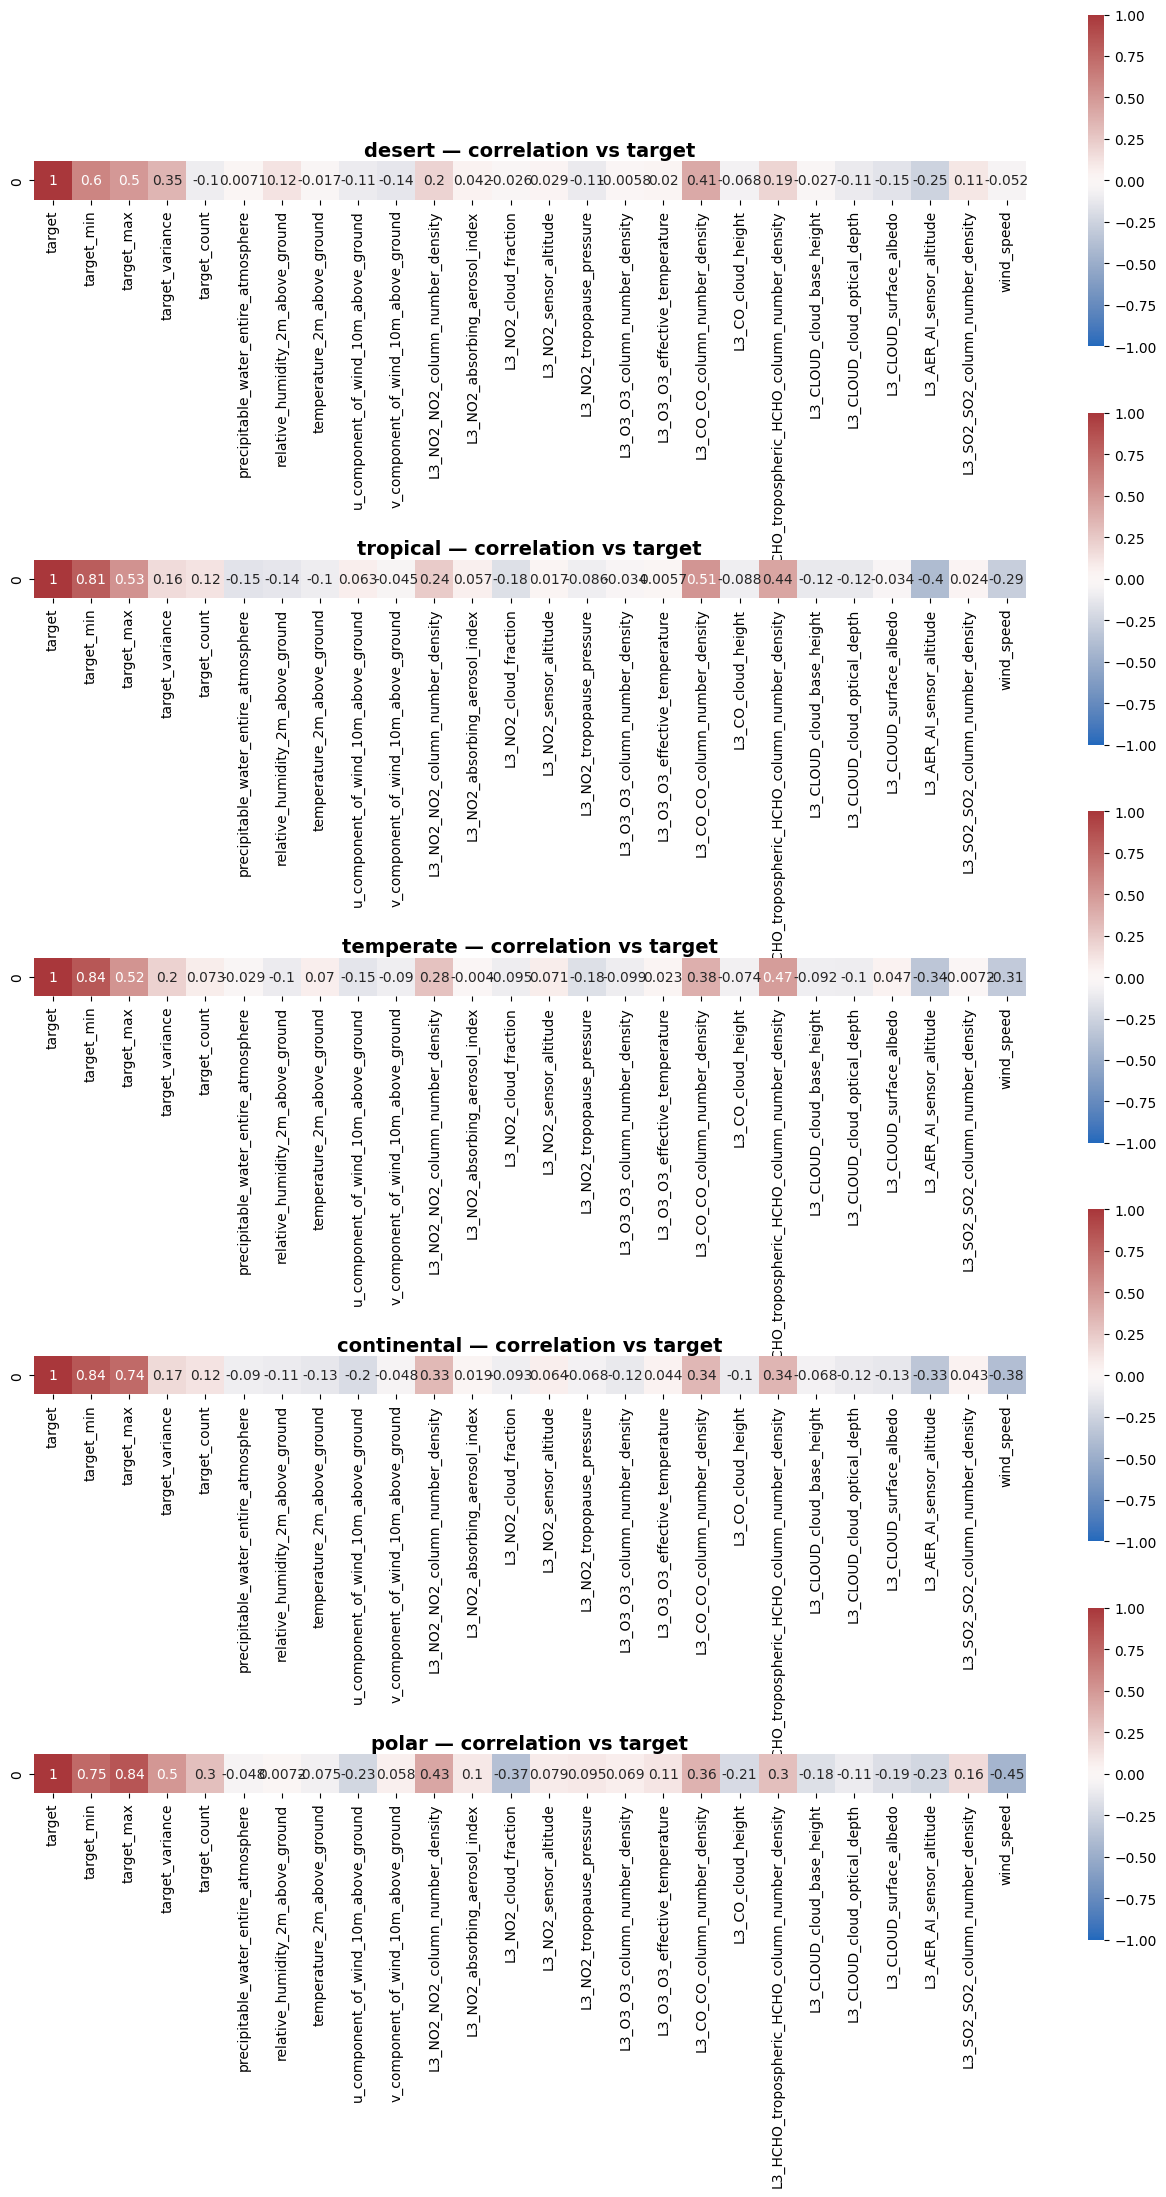

In [73]:
features = [
    'temperature_2m_above_ground',
    'relative_humidity_2m_above_ground',
    'precipitable_water_entire_atmosphere',
    'L3_CLOUD_cloud_optical_depth',
    'wind_speed',
    'target']


bins=df.sort_values('temperature_2m_above_ground')
temp=bins
tropical = temp[temp['temperature_2m_above_ground'] > 25]
subtropical_desert = temp[
    (temp['temperature_2m_above_ground'] > 18) &
    (temp['temperature_2m_above_ground'] < 30)]
#print(subtropical_desert.sort_values('precipitable_water_entire_atmosphere'))
desert = subtropical_desert[(subtropical_desert['precipitable_water_entire_atmosphere'] < 15)]
#print(desert)
tropical = subtropical_desert[(subtropical_desert['precipitable_water_entire_atmosphere'] >=15)]
temperate = temp[
    (temp['temperature_2m_above_ground'] > 10) &
    (temp['temperature_2m_above_ground'] <= 18)]
continental = temp[
    (temp['temperature_2m_above_ground'] > -10) &
    (temp['temperature_2m_above_ground'] <= 10)]
polar = temp[
    (temp['temperature_2m_above_ground'] < -10)]

print('polar',polar.shape)
print('continental',continental.shape)
print('temperate',temperate.shape)
print('desert',desert.shape)
print('tropical',tropical.shape)
zone_dfs = {
    'desert': desert,
    'tropical': tropical,        
    'temperate': temperate,
    'continental': continental,
    'polar': polar}

fig, axes = plt.subplots(5, 1, figsize=(16, 25))
axes = axes.flatten()

target = 'target'

for ax, (name, dfz) in zip(axes, zone_dfs.items()):
    num = dfz.select_dtypes(include='number')
    if target not in num.columns:
        ax.axis('off'); ax.set_title(f"{name}: '{target}' missing"); continue

    # 1×N frame: y-axis is just the target feature
    sub = num.corrwith(num[target]).to_frame().T
    sns.heatmap(sub, annot=True, vmin=-1, vmax=1, cmap='vlag', center=0,
            square=True, ax=ax)
    ax.set_title(f"{name} — correlation vs {target}",fontsize=14, fontweight='bold', pad=4)



## HERE WE ALSO MAKE DIFFERENT DATASETS

In [40]:
by_place_no2 = (
    df.groupby('Place_ID', as_index=False)[
        ['L3_NO2_NO2_column_number_density', 'target', 'target_min', 'target_max']
    ].mean()
      .rename(columns={'L3_NO2_NO2_column_number_density': 'avg_NO2','target':'avg_target','target_min':'avg_target_min','target_max':'avg_target_max'})
      .sort_values('avg_target')
)
#print(by_place_no2)

rural = df[
    (df['L3_NO2_NO2_column_number_density'] < 0.0001)]

peri_urban= df[
    (df['L3_NO2_NO2_column_number_density'] >= 0.0001) & (df['L3_NO2_NO2_column_number_density'] <0.0003)]

urban = df[
    (df['L3_NO2_NO2_column_number_density'] > 0.0003)]


good = df[df['target'] < 15]

moderate = df[
    (df['target'] >= 15) & (df['target'] < 35)
]

unhealthy = df[
    (df['target'] >= 35) & (df['target'] < 55)
]

very_unhealthy = df[
    (df['target'] >= 55) & (df['target'] < 150)
]

hazardous = df[
    (df['target'] >= 150) & (df['target'] <= 200)
]

extreme = df[df['target'] > 200]

print(f"Good:            {good.shape}")
print(f"Moderate:        {moderate.shape}")
print(f"Unhealthy:       {unhealthy.shape}")
print(f"Very Unhealthy:  {very_unhealthy.shape}")
print(f"Hazardous:       {hazardous.shape}")
print(f"Extreme:         {extreme.shape}")

Good:            (2178, 32)
Moderate:        (8759, 32)
Unhealthy:       (5587, 32)
Very Unhealthy:  (11712, 32)
Hazardous:       (2065, 32)
Extreme:         (256, 32)


In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer

def print_eval_metrics(y_test,y_pred, model_name):
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Results")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²:   {r2:.3f}")


RSEED=826

def baseline_model(df, target_col, feature_cols=None, random_state=RSEED):
    if feature_cols == None:
        feature_cols = df.select_dtypes(include='number').columns.drop(target_col)

    X = df[feature_cols]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state) #, test_size=0.2

    # fill nan with median of train data
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_train.median())

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # evaluation
    print_eval_metrics(y_test,y_pred,"Linear Regression")

    return model, y_pred


# your selected features
cols = [
    "precipitable_water_entire_atmosphere",
    "relative_humidity_2m_above_ground",
    "u_component_of_wind_10m_above_ground",
    "v_component_of_wind_10m_above_ground"
]

zone_dfs = {
    'desert': desert,
    'tropical': tropical,
    'temperate': temperate,
    'continental': continental,
    'polar': polar,
    'rural': rural,
    'peri-urban': peri_urban,
    'urban':urban,
    'good': good,
    'moderate': moderate,
    'unhealthy': unhealthy,
    'very_unhealthy': very_unhealthy,
    'hazardous': hazardous,
    'extreme': extreme}

for name, df_zone in zone_dfs.items():


    print(f"\n=== {name.upper()} ===")
    mdl, pred = baseline_model(
        df_zone, target_col="target", feature_cols=cols,
        random_state=RSEED)







=== DESERT ===
Linear Regression Results
RMSE: 35.614
R²:   0.031

=== TROPICAL ===
Linear Regression Results
RMSE: 47.123
R²:   0.028

=== TEMPERATE ===
Linear Regression Results
RMSE: 43.652
R²:   0.032

=== CONTINENTAL ===
Linear Regression Results
RMSE: 43.301
R²:   0.046

=== POLAR ===
Linear Regression Results
RMSE: 71.462
R²:   0.079

=== RURAL ===
Linear Regression Results
RMSE: 41.903
R²:   0.025

=== PERI-URBAN ===
Linear Regression Results
RMSE: 49.305
R²:   0.012

=== URBAN ===
Linear Regression Results
RMSE: 61.161
R²:   0.077

=== GOOD ===
Linear Regression Results
RMSE: 3.217
R²:   0.003

=== MODERATE ===
Linear Regression Results
RMSE: 5.767
R²:   0.005

=== UNHEALTHY ===
Linear Regression Results
RMSE: 5.810
R²:   -0.002

=== VERY_UNHEALTHY ===
Linear Regression Results
RMSE: 24.256
R²:   0.003

=== HAZARDOUS ===
Linear Regression Results
RMSE: 13.519
R²:   0.035

=== EXTREME ===
Linear Regression Results
RMSE: 103.061
R²:   -0.106


In [89]:
# define train and test data and exclude columns of location and date as well as descriptive metrics of target
cols_places = ['Place_ID X Date', 'Date', 'Place_ID','zone', 'co_bin', 'no2_bin','voc_bin','wind_bin']
cols_target = ['target', 'target_min', 'target_max', 'target_variance', 'target_count']





## HERE WE DO CREATE 5 MODELS AND HAVE ONLY 5 SCORES FOR CHECKING 

In [ ]:
RSEED = 42
TARGET = 'target'  # your target column
zone_col     = 'zone'       # created earlier
co_bin_col = 'co_bin'   # created earlier
no2_bin_col  = 'no2_bin'    # created earlier
voc_bin_col='voc_bin'
wind_bin_col='wind_bin'

train_full, test_holdout = train_test_split(
    df, test_size=0.2, random_state=RSEED, shuffle=True
)

def split_Xy(df_part):
    X = df_part.drop(cols_places + cols_target, axis=1)
    y = df_part[TARGET]
    return X, y

def make_model_pipeline(X_train):
    num_cols_all = X_train.select_dtypes('number').columns.tolist()
    skew_thresh = 0.5
    skew_vals = X_train[num_cols_all].apply(lambda x: x.skew()).sort_values(ascending=False)
    skew_cols = skew_vals[abs(skew_vals) > skew_thresh].index.tolist()
    num_cols = list(set(num_cols_all) - set(skew_cols))

    preprocessor = ColumnTransformer([
        ('skewed', Pipeline([
            ('imputer', KNNImputer(n_neighbors=5)),
            ('power', PowerTransformer(method='yeo-johnson')),
            ('scaler', RobustScaler())
        ]), skew_cols),
        ('normal', Pipeline([
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', RobustScaler())
        ]), num_cols)
    ], remainder='drop', verbose_feature_names_out=False)

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(
            n_estimators=250,
            max_depth=15,
            max_features='sqrt',
            random_state=RSEED,
            n_jobs=-1
        ))
    ])
    return model

# ==== 2) Train three families of experts on train_full only ====
zone_models, co_models, no2_models, voc_models, wind_models = {}, {}, {}, {}, {}

for z in train_full[zone_col].astype(str).unique():
    dfz = train_full[train_full[zone_col].astype(str) == z]
    Xz, yz = split_Xy(dfz)
    m = make_model_pipeline(Xz)
    m.fit(Xz, yz)
    zone_models[z] = m
    #print(f"trained ZONE expert: {z} (n={len(dfz)})")

for b in train_full[co_bin_col].astype(str).unique():
    dfc = train_full[train_full[co_bin_col].astype(str) == b]
    Xc, yc = split_Xy(dfc)
    m = make_model_pipeline(Xc)
    m.fit(Xc, yc)
    co_models[b] = m


for c in train_full[no2_bin_col].astype(str).unique():
    dfn = train_full[train_full[no2_bin_col].astype(str) == c]
    Xn, yn = split_Xy(dfn)
    m = make_model_pipeline(Xn)
    m.fit(Xn, yn)
    no2_models[c] = m

for a in train_full[voc_bin_col].astype(str).unique():
    dfvc = train_full[train_full[voc_bin_col].astype(str) == a]
    Xvc, yvc = split_Xy(dfvc)
    m = make_model_pipeline(Xvc)
    m.fit(Xvc, yvc)
    voc_models[a] = m


for w in train_full[wind_bin_col].astype(str).unique():
    dfw = train_full[train_full[wind_bin_col].astype(str) == w]
    Xw, yw = split_Xy(dfw)
    m = make_model_pipeline(Xw)
    m.fit(Xw, yw)
    wind_models[w] = m 


# ==== 3) Get 3 predictions per row on the ONE test set ====
X_test = test_holdout.drop(cols_places + cols_target, axis=1)
y_test = test_holdout[TARGET].values

n = len(test_holdout)
p_zone = np.empty(n);  p_zone[:] = np.nan
p_co   = np.empty(n);  p_co[:]   = np.nan
p_no2  = np.empty(n);  p_no2[:]  = np.nan
p_voc   = np.empty(n);  p_voc[:]   = np.nan
p_wind   = np.empty(n);  p_wind[:]   = np.nan

# Precompute arrays once for quick masking
zone_vals = test_holdout[zone_col].astype(str).values
co_vals   = test_holdout[co_bin_col].astype(str).values
no2_vals  = test_holdout[no2_bin_col].astype(str).values
voc_vals  = test_holdout[voc_bin_col].astype(str).values
wind_vals  = test_holdout[wind_bin_col].astype(str).values

# 1) Zone experts — batch per zone
for zkey, model in zone_models.items():
    idxs = np.where(zone_vals == str(zkey))[0]
    if idxs.size == 0: 
        continue
    Xb = X_test.iloc[idxs]
    p_zone[idxs] = model.predict(Xb)

# 2) co experts — batch per bin
for cokey, model in co_models.items():
    idxs = np.where(co_vals == str(cokey))[0]
    if idxs.size == 0:
        continue
    Xb = X_test.iloc[idxs]
    p_co[idxs] = model.predict(Xb)

# 3) NO2 experts — batch per bin (skip ones you didn't train, e.g. 'unknown')
for nkey, model in no2_models.items():
    idxs = np.where(no2_vals == str(nkey))[0]
    if idxs.size == 0:
        continue
    Xb = X_test.iloc[idxs]
    p_no2[idxs] = model.predict(Xb)

for vockey, model in voc_models.items():
    idxs = np.where(voc_vals == str(vockey))[0]
    if idxs.size == 0:
        continue
    Xb = X_test.iloc[idxs]
    p_voc[idxs] = model.predict(Xb)


for wkey, model in wind_models.items():
    idxs = np.where(wind_vals == str(wkey))[0]
    if idxs.size == 0:
        continue
    Xb = X_test.iloc[idxs]
    p_wind[idxs] = model.predict(Xb)

# --- ZONE expert ---
rmse_zone = root_mean_squared_error(y_test, p_zone)
r2_zone   = r2_score(y_test, p_zone)

# --- WIND expert ---
rmse_wind = root_mean_squared_error(y_test, p_wind)
r2_wind   = r2_score(y_test, p_wind)

# --- co expert ---
mask_co = ~np.isnan(p_co)
if mask_co.any():
    rmse_co = root_mean_squared_error(y_test[mask_co], p_co[mask_co])
    r2_co   = r2_score(y_test[mask_co], p_co[mask_co])
else:
    rmse_co, r2_co = float('nan'), float('nan')

# --- NO2 expert (only where we have a prediction) ---
mask_no2 = ~np.isnan(p_no2)
if mask_no2.any():
    rmse_no2 = root_mean_squared_error(y_test[mask_no2], p_no2[mask_no2])
    r2_no2   = r2_score(y_test[mask_no2], p_no2[mask_no2])
else:
    rmse_no2, r2_no2 = float('nan'), float('nan')


mask_voc = ~np.isnan(p_voc)
if mask_voc.any():
    rmse_voc = root_mean_squared_error(y_test[mask_voc], p_voc[mask_voc])
    r2_voc   = r2_score(y_test[mask_voc], p_voc[mask_voc])
else:
    rmse_voc, r2_voc = float('nan'), float('nan')

print("\nPer-expert performance on the SAME test set")
print(f"ZONE  → RMSE = {rmse_zone:.4f} | R² = {r2_zone:.4f}")
print(f"CO → RMSE = {rmse_co:.4f}   | R² = {r2_co:.4f} (on {mask_co.sum()} rows)")
print(f"NO2   → RMSE = {rmse_no2:.4f}  | R² = {r2_no2:.4f}  (on {mask_no2.sum()} rows)")
print(f"VOC → RMSE = {rmse_voc:.4f}   | R² = {r2_voc:.4f} (on {mask_voc.sum()} rows)")
print(f"WIND → RMSE = {rmse_wind:.4f}   | R² = {r2_wind:.4f}")


Per-expert performance on the SAME test set
ZONE  → RMSE = 31.3372 | R² = 0.5536
CO → RMSE = 31.3018   | R² = 0.5547 (on 6112 rows)
NO2   → RMSE = 31.4795  | R² = 0.5496  (on 6112 rows)
VOC → RMSE = 31.9418   | R² = 0.5363 (on 6112 rows)
WIND → RMSE = 32.1371   | R² = 0.5306


## BLENDING

In [91]:
#Make a validation split from your training data
#the blender must learn weights without ever seeing the test set.
tr, val = train_test_split(train_full, test_size=0.2, random_state=RSEED, shuffle=True)

#Train temporary expert families on tr
#We train the same kind of experts you already trained, 
#but only on tr (so that their predictions on val are clean):

def train_families(df_src):
    zm, co, nm, vocm, wm= {}, {}, {}, {}, {}
    for z in df_src[zone_col].astype(str).unique():
        part = df_src[df_src[zone_col].astype(str) == z]
        Xz, yz = split_Xy(part)
        zm[z] = make_model_pipeline(Xz).fit(Xz, yz)
    for c in df_src[co_bin_col].astype(str).unique():
        part = df_src[df_src[co_bin_col].astype(str) == c]
        Xc, yc = split_Xy(part)
        co[c] = make_model_pipeline(Xc).fit(Xc, yc)
    for b in df_src[no2_bin_col].astype(str).unique():
        part = df_src[df_src[no2_bin_col].astype(str) == b]
        Xn, yn = split_Xy(part)
        nm[b] = make_model_pipeline(Xn).fit(Xn, yn)
    for a in df_src[voc_bin_col].astype(str).unique():
        part = df_src[df_src[voc_bin_col].astype(str) == a]
        Xvc, yvc = split_Xy(part)
        vocm[a] = make_model_pipeline(Xvc).fit(Xvc, yvc)
    for w in df_src[wind_bin_col].astype(str).unique():
        part = df_src[df_src[wind_bin_col].astype(str) == w]
        Xw, yw = split_Xy(part)
        wm[w] = make_model_pipeline(Xw).fit(Xw, yw)
    return zm, co, nm, vocm, wm

zm_tr, co_tr, nm_tr, voc_tr, wind_tr = train_families(tr)


#Get validation predictions (the blender’s features)
#For each row in val, get the 3 expert predictions as a feature vector
#yzone,ypm,yno2
#This is just like we did for test_holdout, 
#but applied to val with the *_tr models:
def batch_preds(frame, zm, com, nm, vocm, wm):
    Xf = frame.drop(cols_places + cols_target, axis=1)
    n  = len(frame)
    out_z = np.full(n, np.nan)
    out_co = np.full(n, np.nan)
    out_n = np.full(n, np.nan)
    out_vc = np.full(n, np.nan)
    out_w = np.full(n, np.nan)

    zv = frame[zone_col].astype(str).values
    cov = frame[co_bin_col].astype(str).values
    nv = frame[no2_bin_col].astype(str).values
    vcv = frame[voc_bin_col].astype(str).values
    wv = frame[wind_bin_col].astype(str).values

    for key, model in zm.items():
        idxs = np.where(zv == str(key))[0]
        if idxs.size: out_z[idxs] = model.predict(Xf.iloc[idxs])
    for key, model in com.items():
        idxs = np.where(cov == str(key))[0]
        if idxs.size: out_co[idxs] = model.predict(Xf.iloc[idxs])
    for key, model in nm.items():
        idxs = np.where(nv == str(key))[0]
        if idxs.size: out_n[idxs] = model.predict(Xf.iloc[idxs])
    for key, model in vocm.items():
        idxs = np.where(vcv == str(key))[0]
        if idxs.size: out_vc[idxs] = model.predict(Xf.iloc[idxs])
    for key, model in wm.items():
        idxs = np.where(wv == str(key))[0]
        if idxs.size: out_w[idxs] = model.predict(Xf.iloc[idxs])

    return np.c_[out_z, out_co, out_n, out_vc, out_w], frame[TARGET].values

X_val_blend, y_val = batch_preds(val, zm_tr, co_tr, nm_tr, voc_tr, wind_tr)

mask_all_nan = np.isnan(X_val_blend).all(axis=1)
mask_all_nan_2 = np.isnan(y_val).all()
print(f"Rows with all experts NaN: {mask_all_nan.sum()}")
print(mask_all_nan_2.sum())


print("NaNs per column:", np.isnan(X_val_blend).sum(axis=0))      # counts per expert
print("All-NaN columns:", np.isnan(X_val_blend).all(axis=0))      # True = this expert col is entirely NaN
print("Total NaNs in y_val:", int(np.isnan(y_val).sum()))

#Fit the blender (a linear regression on those 3 columns)
#We’ll use non-negative weights (nice & interpretable). 
# We may have NaN in the NO₂ column; 
# train on rows where all three predictions exist:

# --- 3) Fit the blender ---
blend = LinearRegression()
blend.fit(X_val_blend, y_val)
wz, wco, wn, wvc, ww = blend.coef_.tolist()
b0 = blend.intercept_
print("Blend weights:", {"wind": ww,"zone": wz, "co": wco, "no2": wn, "voc": wvc}, "intercept:", b0)



# --- 4) Prepare test experts and fill NaNs with the SAME column means ---
P = np.c_[p_zone, p_co, p_no2, p_voc, p_wind].astype(float)   # shape (n_test, 4)
# with VOC
blend_full = LinearRegression().fit(X_val_blend, y_val)
pred_full  = blend.predict(P)
print("With VOC:", r2_score(y_test, pred_full), root_mean_squared_error(y_test, pred_full))

# without VOC (drop column 3)
X_wo = np.delete(X_val_blend, 3, axis=1)
P_wo = np.delete(P, 3, axis=1)
blend_wo = LinearRegression().fit(X_wo, y_val)
pred_wo  = blend_wo.predict(P_wo)
print("Without VOC:", r2_score(y_test, pred_wo), root_mean_squared_error(y_test, pred_wo))

from sklearn.linear_model import Ridge
blend_r = Ridge(alpha=1.0).fit(X_val_blend, y_val)
pred_r  = blend_r.predict(P)
print("Ridge blend R²/RMSE:", r2_score(y_test, pred_r), root_mean_squared_error(y_test, pred_r))
print("Ridge weights:", dict(zip(['zone','co','no2','voc',"wind"], blend_r.coef_)), "b0:", blend_r.intercept_)








Rows with all experts NaN: 0
0
NaNs per column: [0 0 0 0 0]
All-NaN columns: [False False False False False]
Total NaNs in y_val: 0
Blend weights: {'wind': -0.1793659591858038, 'zone': 0.7664046953264779, 'co': 0.40834481094559416, 'no2': 0.23620914169375212, 'voc': 0.0065685784309864} intercept: -14.942646716787564
With VOC: 0.582558146569655 30.305365499806758
Without VOC: 0.5825497232629973 30.305671255083997
Ridge blend R²/RMSE: 0.5825581431567834 30.305365623690264
Ridge weights: {'zone': 0.7664021942399578, 'co': 0.40834352602755675, 'no2': 0.23620907101101843, 'voc': 0.006569400027381019, 'wind': -0.17936297555828581} b0: -14.942643474034782


In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso
import numpy as np
import pandas as pd

blend_cols = ['zone','co','no2','voc','wind']


# CV & scoring
cv = KFold(n_splits=5, shuffle=True, random_state=RSEED)
scoring = 'neg_root_mean_squared_error'

pipe = Pipeline([
    ('est', Ridge())  # placeholder; grid swaps estimator
])

# alphas (same span you used)
alphas_ridge = np.logspace(-4, 4, 15)
alphas_lasso = np.logspace(-4, 4, 15)

param_grid = [
    # match your manual Ridge (positive=True)
    {'est': [Ridge(max_iter=5000)], 'est__alpha': alphas_ridge},
    {'est': [Lasso(max_iter=5000)], 'est__alpha': alphas_lasso},
]

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring=scoring, n_jobs=-1, refit=True)
grid.fit(X_val_blend, y_val)

best_model = grid.best_estimator_
print("Best blender:", best_model)
print("Best CV RMSE:", -grid.best_score_)

# Evaluate on test-blend P
pred = best_model.predict(P)
rmse = root_mean_squared_error(y_test, pred)
r2   = r2_score(y_test, pred)
print(f"Test R²/RMSE: {r2:.4f} / {rmse:.4f}")

Best blender: Pipeline(steps=[('est', Lasso(alpha=3.727593720314938, max_iter=5000))])
Best CV RMSE: 28.98697071547452
Test R²/RMSE: 0.5809 / 30.3657


In [81]:
def slice_scores(frame, y_true, pred_r, by, min_rows=30, sort='rmse'):
    """
    frame : DataFrame with the slice columns (e.g., zone/no2_bin/co_bin)
    y_true: 1D array of true targets aligned to frame
    y_pred: 1D array of predictions aligned to frame
    by    : list of column names to group by (e.g., ['zone','no2_bin','co_bin'])
    min_rows : require at least this many rows per slice; smaller ones get NaN metrics
    sort : 'rmse' (asc) or 'r2' (desc)
    """
    df_ = frame.copy()
    df_['y_true'] = np.asarray(y_true)
    df_['y_pred'] = np.asarray(pred_r)

    def stats(g):
        n = len(g)
        if n < min_rows:
            return pd.Series({'n': n, 'rmse': np.nan, 'r2': np.nan})
        rmse = root_mean_squared_error(g['y_true'], g['y_pred'])
        r2   = r2_score(g['y_true'], g['y_pred'])
        return pd.Series({'n': n, 'rmse': rmse, 'r2': r2})

    out = df_.groupby(by, dropna=False).apply(stats).reset_index()
    if sort == 'rmse':
        out = out.sort_values(['rmse','n'], ascending=[True, False])
    elif sort == 'r2':
        out = out.sort_values(['r2','n'], ascending=[False, False])
    return out


# Build the slice table (example)
tbl = slice_scores(test_holdout, y_test, pred_r,
                   by=['zone','no2_bin','co_bin','voc_bin',"wind_bin"])

# 1) Max n across all slices
max_n = tbl['n'].max()
print("Max n:", max_n)
print('====================')

# 2) Which slice(s) have that max n
print(tbl[tbl['n'] == max_n])
print('====================')


# 3) Top-10 slices by n
print(tbl.head(50))
print('====================')




# 4) Also useful: show n as % of total test rows
total = len(test_holdout)
tbl = tbl.assign(n_pct=(tbl['n'] / total * 100).round(2))
#print(tbl.sort_values('n', ascending=False).head(10)[['zone','no2_bin','co_bin','voc_bin','n','n_pct']])

Max n: 481.0
          zone no2_bin  co_bin     voc_bin wind_bin      n       rmse   
4  continental   rural  low_co  background    light  481.0  30.282489  \

         r2  
4  0.386563  
             zone     no2_bin       co_bin     voc_bin wind_bin      n   
977     temperate       rural       low_co     unknown   breezy   32.0  \
6     continental       rural       low_co  background    windy   50.0   
65    continental       rural      unknown  background   breezy   31.0   
976     temperate       rural       low_co     unknown    light   36.0   
965     temperate       rural       low_co  background   breezy  168.0   
9     continental       rural       low_co         low   breezy   63.0   
17    continental       rural       low_co     unknown   breezy  150.0   
964     temperate       rural       low_co  background    light  231.0   
1357     tropical       rural      unknown     unknown   breezy   37.0   
1289     tropical       rural       low_co         low   breezy   86.0  

## HERE WE DO CREATE A LOT OF MODELS

In [ ]:
for name, df_zone in zone_dfs.items():

    df_train, df_test = train_test_split(df_zone, random_state=RSEED)
    X_train = df_train.drop(cols_places + cols_target, axis=1)
    X_test = df_test.drop(cols_places + cols_target, axis=1)
    y_train = df_train['target']
    y_test = df_test['target']
  
    print(f"\n=== {name.upper()} ===")

    # select numerical cols
    num_cols = X_train.select_dtypes('number').columns.tolist()

    # identify skewed cols
    skew_thresh = 0.5
    skew_cols2 = X_train[num_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
    skew_cols = skew_cols2[abs(skew_cols2) > skew_thresh].index.tolist()
    #print(f"{len(skew_cols)} skewed cols: {skew_cols}")

    # only select numerical cols which arent skewed
    num_cols = list(set(num_cols) - set(skew_cols))
    #print(f"{len(num_cols)}     num cols:",num_cols)

    preprocessor = ColumnTransformer([
        ('skewed', Pipeline([
            ('imputer', KNNImputer(n_neighbors=5)),
            ('power', PowerTransformer(method='yeo-johnson')),
            ('scaler', RobustScaler())
        ]), skew_cols),

        ('normal', Pipeline([
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', RobustScaler())
        ]), num_cols)
    ])

    model = Pipeline([
       ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(
            n_estimators=250,
            max_depth=15,
            # min_samples_split=5,
            # min_samples_leaf=3,
            max_features='sqrt', #log2
            random_state=RSEED,
            n_jobs=-1
        ))
    ])

    model.fit(X_train, y_train)    # applies all steps in pipeline to train-data
    y_pred = model.predict(X_test) # apply same to test-data

    # evaluation
    modelname = model.named_steps['model'].__class__.__name__
    print_eval_metrics(y_test,y_pred,modelname)

    rf = model.named_steps['model']
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()

    importances = pd.Series(rf.feature_importances_, index=feature_names)

    max_feature = importances.idxmax()   # name of feature
    max_value = importances.max() 



=== DESERT ===
RandomForestRegressor Results
RMSE: 74.889
R²:   0.159

=== TROPICAL ===
RandomForestRegressor Results
RMSE: 26.258
R²:   0.629

=== TEMPERATE ===
RandomForestRegressor Results
RMSE: 26.870
R²:   0.612

=== CONTINENTAL ===
RandomForestRegressor Results
RMSE: 29.723
R²:   0.537

=== POLAR ===
RandomForestRegressor Results
RMSE: 40.526
R²:   0.701

=== RURAL ===
RandomForestRegressor Results
RMSE: 26.751
R²:   0.558

=== PERI-URBAN ===
RandomForestRegressor Results
RMSE: 35.480
R²:   0.532

=== URBAN ===
RandomForestRegressor Results
RMSE: 45.927
R²:   0.474

=== GOOD ===
RandomForestRegressor Results
RMSE: 2.774
R²:   0.239

=== MODERATE ===
RandomForestRegressor Results
RMSE: 5.447
R²:   0.118

=== UNHEALTHY ===
RandomForestRegressor Results
RMSE: 5.583
R²:   0.039

=== VERY_UNHEALTHY ===
RandomForestRegressor Results
RMSE: 20.249
R²:   0.286

=== HAZARDOUS ===
RandomForestRegressor Results
RMSE: 11.734
R²:   0.241

=== EXTREME ===
RandomForestRegressor Results
RMSE: 45